## 20190315

【训练优化】  
让验证集loss不在震荡；通过数据增强等方法降低loss

**问题：train和val上表现良好，test上表现巨差。**  
（后发现有test序号错乱的问题）

- 图像归一化
  - `cv2.normalize` 这个是归一化，将图像压缩到[0, 1] 有用，有一定防止过拟合的能力
- 灰度化处理
  - `img = cv2.imread(TRAIN_DIR+'cat.0.jpg', cv2.IMREAD_GRAYSCALE)`
- 数据增强
  - `ImageDataGenerator()`  旋转10，缩放0.1，左右上下平移0.1，水平翻转，（没有竖直翻转）
  - 可防止过拟合，在使验证集loss不再起飞
- 训练优化
  - 早停
    - `early_stopping = EarlyStopping(monitor='val_loss', patience=6, min_delta=0.0002, verbose=1, mode='auto')`
  - LR自动减小
    - `learning_rate_reduction = ReduceLROnPlateau(xxx)`
  - 保存最优的模型参数
    - `checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')`
- CV读取图片顺序为BGR，plt显示顺序为RGB
  - `img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2默认为bgr顺序`

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, MaxPooling2D, Dense, Activation, Conv2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
from keras import backend
backend.set_image_dim_ordering('tf')  # th通道最前，tf通道最后

In [3]:
import os
import tensorflow as tf
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

## Preparing the Data

This function resizes the images to 64x64 and samples 2000 images (8%) of the data to run efficiently as a Kaggle Kernel. I also separated cats and dogs for exploratory analysis. 

In [4]:
TRAIN_DIR = './data/train/'
TEST_DIR = './data/test/'

ROWS = 128
COLS = 128
CHANNELS = 3
GRAY_CHANNEL = 1

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
#train_images = train_dogs[:3000] + train_cats[:3000]
#np.random.shuffle(train_images)  后面model.fit()有
#test_images =  test_images[:500]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images, is_gray):
    count = len(images)
    if is_gray:
        data = np.ndarray((count, ROWS, COLS, GRAY_CHANNEL), dtype=np.float32)
    else:
        data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        #image = read_image(image_file)
        # 灰度化 -> 修改图片尺寸 -> 存到data中  # 标准化
        if is_gray:
            image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
            image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            image = image.reshape(ROWS, COLS, 1)
            data[i] = image
        else:
            image = cv2.imread(image_file, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
            data[i] = image
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images, is_gray=True)
#test = prep_data(test_images, is_gray=True)

print("Train shape: {}".format(train.shape))
#print("Test shape: {}".format(test.shape))

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000
Train shape: (25000, 128, 128, 1)


In [5]:
TRAIN_DIR = './data/train/'
img = cv2.imread(TRAIN_DIR+'cat.0.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
img = img.reshape(ROWS, COLS, 1)
#img = cv2.imread(TRAIN_DIR+'cat.0.jpg', cv2.IMREAD_COLOR)
img.shape
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#norm_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#plt.imshow(img, cmap='gray')
#plt.figure()
#plt.subplot(1,2,1); plt.imshow(img)
#plt.subplot(1,2,2); plt.imshow(norm_image)

(128, 128, 1)

### Generating the Labels

We're dealing with a binary classification problem here - (1) dog (0) cat. The lables can be created by looping over the file names in the train directory. It's nice to see the training data is perfectly balanced. 

Text(0.5, 1.0, 'Cats and Dogs')

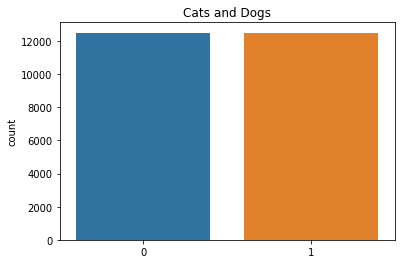

In [6]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
plt.title('Cats and Dogs')

#### Split training and valdiation set

In [7]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(train, labels, test_size = 0.25, random_state=random_seed)

### Checking out Cats and Dogs
A quick side-by-side comparison of the animals.

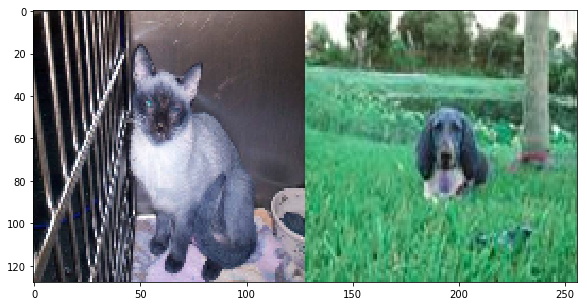

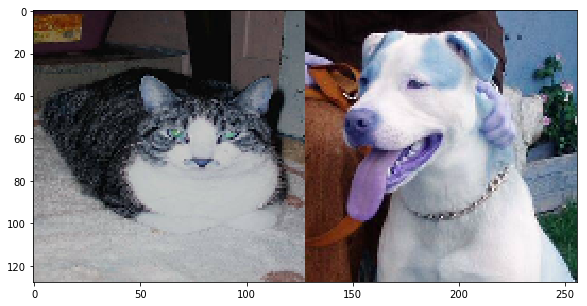

In [8]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,2):
    show_cats_and_dogs(idx)

### Your Average Cat and Dog Photo

Just for fun, the mean pixel values for cats and dogs. I can almost see a resemblance, a ghost, if you will...

Text(0.5, 1.0, 'Your Average Dog')

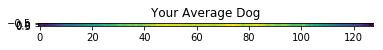

In [9]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
plt.imshow(dog_avg)
plt.title('Your Average Dog')

Text(0.5, 1.0, 'Your Average Cat')

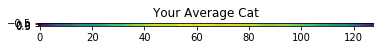

In [10]:
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if labels[i]==0]).mean(axis=0)
plt.imshow(cat_avg)
plt.title('Your Average Cat')

## CatdogNet-16

A scaled down version of the VGG-16, with a few notable changes.

- Number of convolution filters cut in half, fully connected (dense) layers scaled down. 
- Optimizer changed to `RMSprop`. 
- Output layer activation set to `sigmoid` for binary crossentropy. 
- Some layers commented out for efficiency.

The full network takes about 80s per epoch on a GTX1070 (or 2hr+ on CPU) on the full dataset.  (This script only trains on 8% of the 25K images. )

In [11]:
optimizer = RMSprop(lr=8e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(ROWS, COLS, GRAY_CHANNEL), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    '''
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    '''
     

#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 256)       295168    
__________

### Train and Predict

I'm using Keras's early stopping callback to end training when the validation loss stops improving, otherwise the model will overfit. I will also be tracking the loss history on each epoch to visualize the overfitting trend. 

Note: A slice of 1000 images was used to fit the model for CPU efficency. The model's perfrmance improves significantly when used on the entire dataset. 

In [13]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen = ImageDataGenerator()
datagen.fit(X_train)

In [14]:
epochs = 50
batch_size = 128

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

## Callback for loss logging per epoch
'''
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
'''

early_stopping = EarlyStopping(monitor='val_loss', patience=6, min_delta=0.0002, verbose=1, mode='auto')     
filepath="./weights/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
        
def run_catdog():
    
    '''
    #history = LossHistory()
    model_his = model.fit(train, labels, batch_size=batch_size, epochs=epochs,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[learning_rate_reduction, early_stopping, checkpoint])
    '''
     
    model_his = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), shuffle=True, 
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction, early_stopping, checkpoint])

    #predictions = model.predict(test, verbose=1)
    return model_his

history = run_catdog()

Epoch 1/50
146/146 [==============================] - 48s 328ms/step - loss: 0.7308 - acc: 0.5045 - val_loss: 0.6869 - val_acc: 0.5627

Epoch 00001: val_loss improved from inf to 0.68690, saving model to ./weights/weights.best.hdf5
Epoch 2/50
146/146 [==============================] - 44s 301ms/step - loss: 0.6912 - acc: 0.5462 - val_loss: 0.6851 - val_acc: 0.5454

Epoch 00002: val_loss improved from 0.68690 to 0.68507, saving model to ./weights/weights.best.hdf5
Epoch 3/50
146/146 [==============================] - 44s 301ms/step - loss: 0.6956 - acc: 0.5654 - val_loss: 0.6694 - val_acc: 0.5987

Epoch 00003: val_loss improved from 0.68507 to 0.66938, saving model to ./weights/weights.best.hdf5
Epoch 4/50
146/146 [==============================] - 44s 301ms/step - loss: 0.6580 - acc: 0.6199 - val_loss: 0.6251 - val_acc: 0.6830

Epoch 00004: val_loss improved from 0.66938 to 0.62508, saving model to ./weights/weights.best.hdf5
Epoch 5/50
146/146 [==============================] - 44s 30

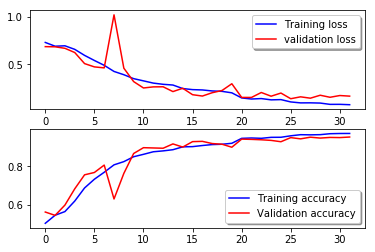

In [15]:
'''
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()
'''

# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## How'd We Do?

I'm pretty sure I can distinguish a cat from a dog 100% of the time, but how confident is the model?...

Tip: Run on the full dataset with a GPU for a LB logloss of ~0.4 and accuracy at approx 90%. 

In [16]:
#test_images =  test_images[:50]
test = prep_data(test_images, is_gray=True)
#test = train[:30]
print("Test shape: {}".format(test.shape))
model.load_weights("./weights/weights.best.hdf5")
predictions = model.predict(test, verbose=1)

Processed 0 of 12500
Processed 1000 of 12500
Processed 2000 of 12500
Processed 3000 of 12500
Processed 4000 of 12500
Processed 5000 of 12500
Processed 6000 of 12500
Processed 7000 of 12500
Processed 8000 of 12500
Processed 9000 of 12500
Processed 10000 of 12500
Processed 11000 of 12500
Processed 12000 of 12500
Test shape: (12500, 128, 128, 1)
12500/12500 [==============================] - 11s 841us/step


In [17]:
'''
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i])
    plt.show()
'''

"\nfor i in range(0,10):\n    if predictions[i, 0] >= 0.5: \n        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))\n    else: \n        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))\n        \n    plt.imshow(test[i])\n    plt.show()\n"

In [18]:
results = (predictions).reshape(-1)

results = pd.Series(results, name="Label")

submission = pd.concat([pd.Series(range(1,12501),name = "id"),results],axis = 1)

submission.to_csv("vgg16_test50_result.csv",index=False)